In [472]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
import compute_diversity_measures
import seaborn as sns

In [473]:
fname_mutations_all_samples = 'mutations_all_samples.csv'
output_dir = './plots_diversity/'

df = pd.read_csv(fname_mutations_all_samples)

df['frequency'] = df['frequency_reads_var']
df['coverage'] = df['n_reads_tot']
df['position'] = df['Pos']

In [474]:
# Post-processing filtering of mutation calling

# filter out where Frq_ave == 0.0 
# that is something unexpected happening in ShoRAH which is due to the super high coverage
df = df[df['Frq_ave']!=0]

# strand bias test 
df = df[df['Pval']>=0.05]

# minimum read support
minimum_read_support = 10 
df = df[df['n_reads_var']>=minimum_read_support]

# minimum mutation frequency
minimum_frequency_threshold = 0.0001 
df = df[df['frequency_reads_var']>=minimum_frequency_threshold]

In [475]:
replicates = df['patient'].unique()
passages = df['passage'].unique()
samples = df['sample'].unique()

In [476]:
genome_length = 9228

In [477]:
def mutation_spectrum(df_mutations, bins):
    counts = np.zeros(len(bins))
    for i, curr_bin in enumerate(bins):
        df_temp = df_mutations[df_mutations["frequency"] >= curr_bin[0]]
        df_temp = df_temp[df_temp["frequency"] <= curr_bin[1]]
        counts[i] = df_temp.shape[0]
    return list(counts)

In [478]:
df_diversity = pd.DataFrame()

for sample in samples:
    for passage in passages:
        for replicate in replicates:
            
            df_temp = df[df['sample']== sample]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['patient']==replicate]
            
            mutation_spectrum_bins = [(0.0001,0.001),(0.001,0.01), (0.01,0.1), (0.1, 1)]
            mutation_spectrum_bins_labels = [str(curr_bin) for curr_bin in mutation_spectrum_bins]
            
            temp_dict = {'sample': sample, 
                         'passage': passage, 
                         'replicate': replicate,
                         'sum_mutation_frq': df_temp["frequency"].sum(), 
                         'mean_mutation_frq': df_temp["frequency"].mean(), 
                         'sem_mutation_frq': sem(df_temp["frequency"].to_numpy()), 
                         'population_nucleotide_diversity': compute_diversity_measures.population_nucleotide_diversity(df_temp, genome_length), 
                         'mean_pos_Shannon_entropy': compute_diversity_measures.mean_pos_Shannon_entropy(df_temp, genome_length),
                         'number_of_polymorphisms': compute_diversity_measures.number_of_polymorphisms(df_temp),
                         'number_of_polymorphisms_freq_thres_0.1': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.1),
                         'number_of_polymorphisms_freq_thres_0.2': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.2),
                         'number_of_polymorphisms_freq_thres_0.3': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.2),
                         'number_of_polymorphisms_freq_thres_0.4': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.2),
                         'number_of_polymorphisms_freq_thres_0.01': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.01),
                         'number_of_polymorphisms_freq_thres_0.001': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.001),
                         'number_of_polymorphisms_freq_thres_0.0001': compute_diversity_measures.number_of_polymorphisms(df_temp, 0.0001),
                         'mutation_spectrum_bins_labels': mutation_spectrum_bins_labels, 
                         'mutation_spectrum': mutation_spectrum(df_temp, mutation_spectrum_bins), 
                         'mutation_spectrum_bins': mutation_spectrum_bins,
                         
                        }
            df_diversity = df_diversity.append(temp_dict, ignore_index=True)

In [479]:
df_wildtype = df_diversity[df_diversity['sample']=='wild_type']
df_ko = df_diversity[df_diversity['sample']=='dicer_ko']
df_overexpressed = df_diversity[df_diversity['sample']=='dicer_overexpressed']

AxesSubplot(0.125,0.657941;0.227941x0.222059)


/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_81699/586012354.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][0].set_xticklabels(labels=mutation_spectrum_bins_labels,rotation = 90, size=25)
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_81699/586012354.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][1].set_xticklabels(labels=mutation_spectrum_bins_labels,rotation = 90, size=25)
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_81699/586012354.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][2].set_xticklabels(labels=mutation_spectrum_bins_labels, rotation = 90, size=25)


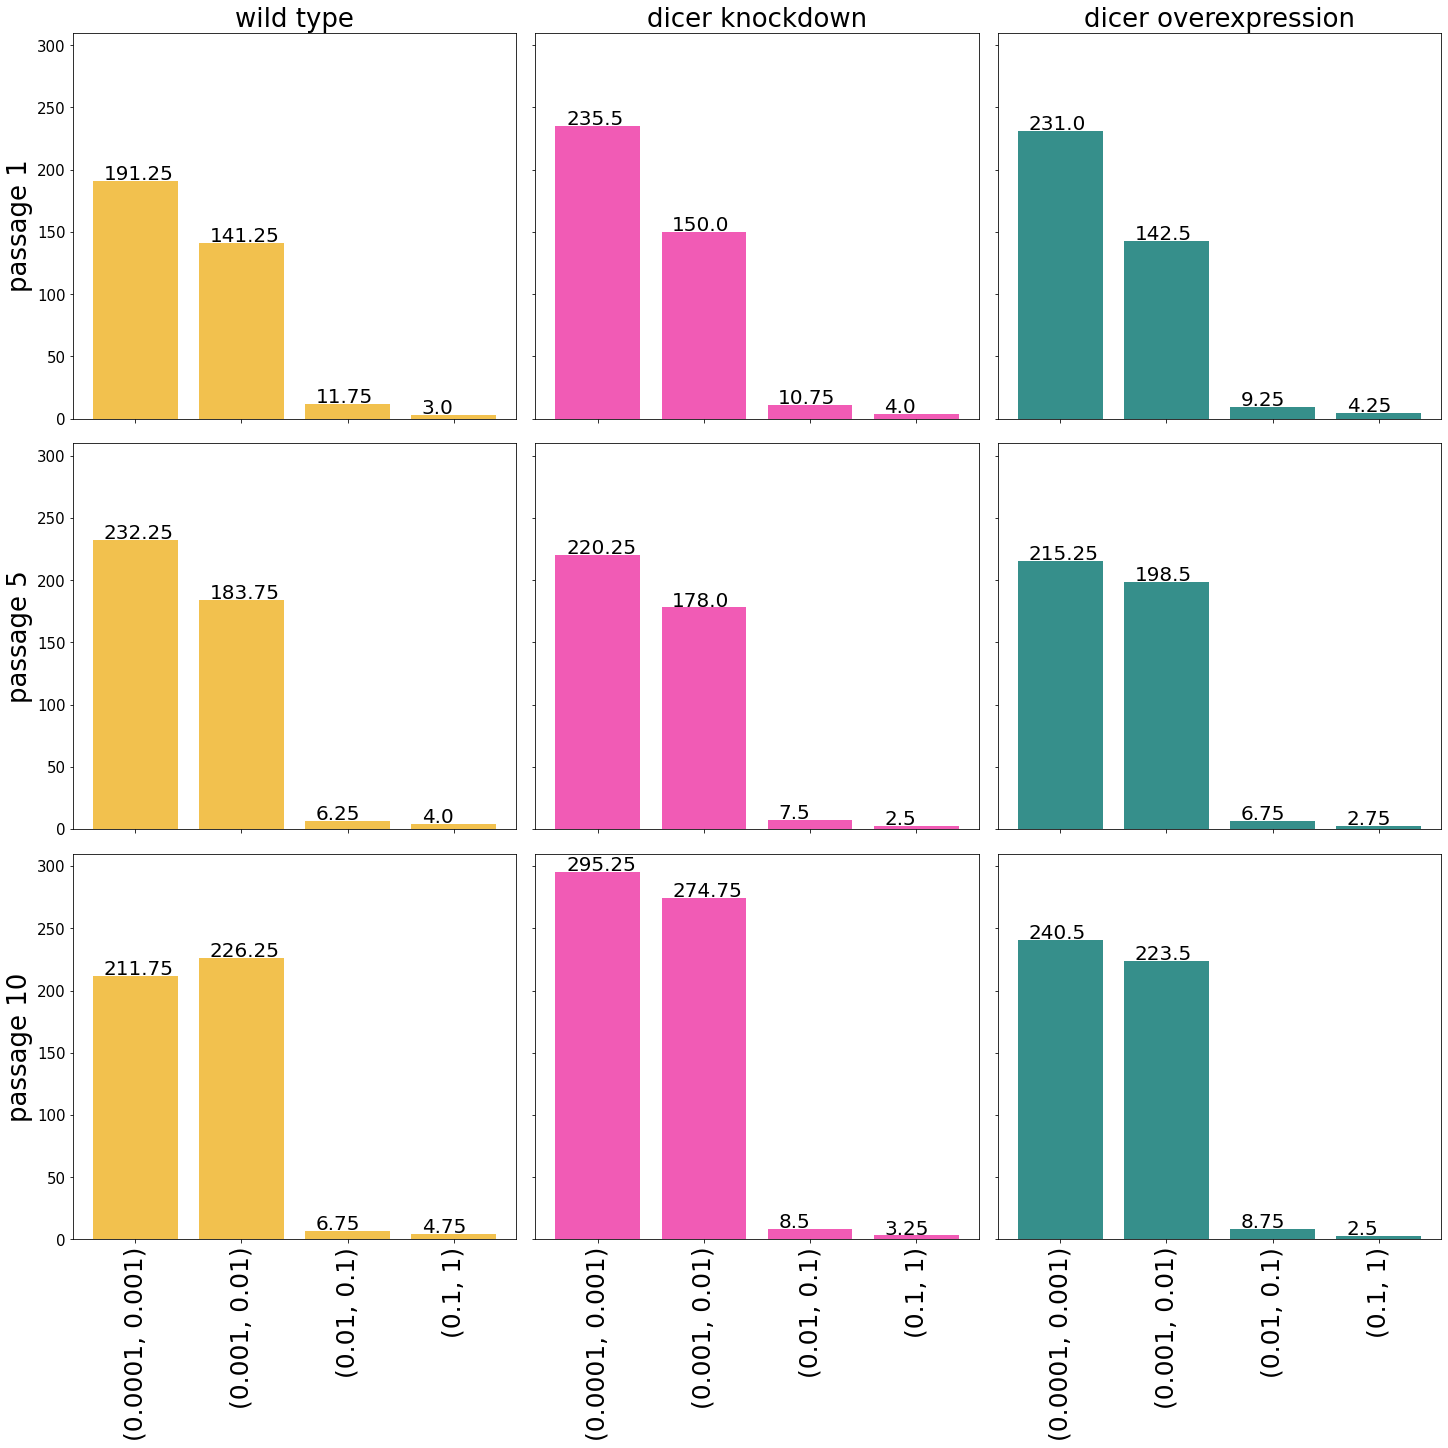

In [483]:
# plot average mutation spectrum (averaged over the replicates)

#['#F2C14E', '#368F8B', '#F15BB5']
#['wild type', 'dicer knockout', 'dicer overexpressed']

plt.rcParams.update({'font.size': 15})

def get_average_bin_values(df_temp):
    length_bins = len(mutation_spectrum_bins)
    ave = np.zeros(length_bins)

    for i in range(length_bins):
        for bins_values in df_temp:
            ave[i] += bins_values[i]
        if ave[i]>0:
            ave[i]=ave[i]/length_bins
    return ave

fig, ax = plt.subplots(3,3, figsize=(20, 20),constrained_layout=True, sharey=True, sharex=True)
passages = [1,5,10]
genotypes = ['wild_type', 'dicer_ko', 'dicer_overexpressed']
print(ax[0][0])

for idx_passage, passage in enumerate(passages):
    df_wildtype = df_diversity[df_diversity['sample']=='wild_type']
    df_ko = df_diversity[df_diversity['sample']=='dicer_ko']
    df_overexpressed = df_diversity[df_diversity['sample']=='dicer_overexpressed']
    
    df_temp = df_wildtype[df_wildtype['passage']==passage]['mutation_spectrum']
    averaged = get_average_bin_values(df_temp)
    ax[idx_passage][0].bar(mutation_spectrum_bins_labels, averaged,label='wild type', color='#F2C14E') 
    for i, v in enumerate(averaged):
                ax[idx_passage][0].text( i - 0.3, v + 1, str(v),
                        color = 'black', size=20)
    
    df_temp = df_ko[df_ko['passage']==passage]['mutation_spectrum']
    averaged = get_average_bin_values(df_temp)
    ax[idx_passage][1].bar(mutation_spectrum_bins_labels, averaged,label='dicer knockdown', color='#F15BB5') 
    for i, v in enumerate(averaged):
                ax[idx_passage][1].text( i - 0.3, v + 1, str(v),
                        color = 'black', size=20)
    
    df_temp = df_overexpressed[df_overexpressed['passage']==passage]['mutation_spectrum']
    averaged = get_average_bin_values(df_temp)
    ax[idx_passage][2].bar(mutation_spectrum_bins_labels, averaged,label='dicer overexpressed', color='#368F8B') 
    for i, v in enumerate(averaged):
                ax[idx_passage][2].text( i - 0.3, v + 1, str(v),
                        color = 'black', size=20)
            

ax[0][0].set_title('wild type',size=26)
ax[0][1].set_title('dicer knockdown',size=26)
ax[0][2].set_title('dicer overexpression',size=26)

ax[0][0].set_ylabel('passage 1',size=26)
ax[1][0].set_ylabel('passage 5',size=26)
ax[2][0].set_ylabel('passage 10',size=26)

ax[2][0].set_xticklabels(labels=mutation_spectrum_bins_labels,rotation = 90, size=25)
ax[2][1].set_xticklabels(labels=mutation_spectrum_bins_labels,rotation = 90, size=25)
ax[2][2].set_xticklabels(labels=mutation_spectrum_bins_labels, rotation = 90, size=25)

        
plt.savefig(output_dir+'Barplot_observed_mutation_frequency_distribution.averaged.pdf',format='pdf')

In [373]:
def plot_mutation_spectrum(df, GT_name, output_dir, GT_color):
    # mutation spectrum bins
    replicates = ['replicate_a', 'replicate_b', 'replicate_c', 'replicate_d', 'replicate_e']

    fig, ax = plt.subplots(5,3, figsize=(20, 20),constrained_layout=True, sharey=True)
    #fig.suptitle('Fr', fontsize=20)

    for idx_rep, rep in enumerate(replicates):
        for idx_vp, vp in enumerate([1,5,10]):
            df_temp = df[df['replicate']==rep]
            df_temp = df_temp[df_temp['passage']==vp]
            #print(str(df_temp['mutation_spectrum'].values[0])

            mut_spec = df_temp['mutation_spectrum'].values[0]
            bins = df_temp['mutation_spectrum_bins_labels'].values[0]

            ax[idx_rep][idx_vp].bar(bins, mut_spec, color=GT_color)
            ax[idx_rep][idx_vp].set_title('passage ' + str(vp))
            ax[idx_rep][idx_vp].set_ylabel(rep)

            for i, v in enumerate(mut_spec):
                ax[idx_rep][idx_vp].text( i - 0.1, v + 10, str(v),
                        color = 'black')

    plt.savefig(output_dir+'Barplot_observed_mutation_frequency_distribution.'+GT_name+'.pdf',format='pdf')

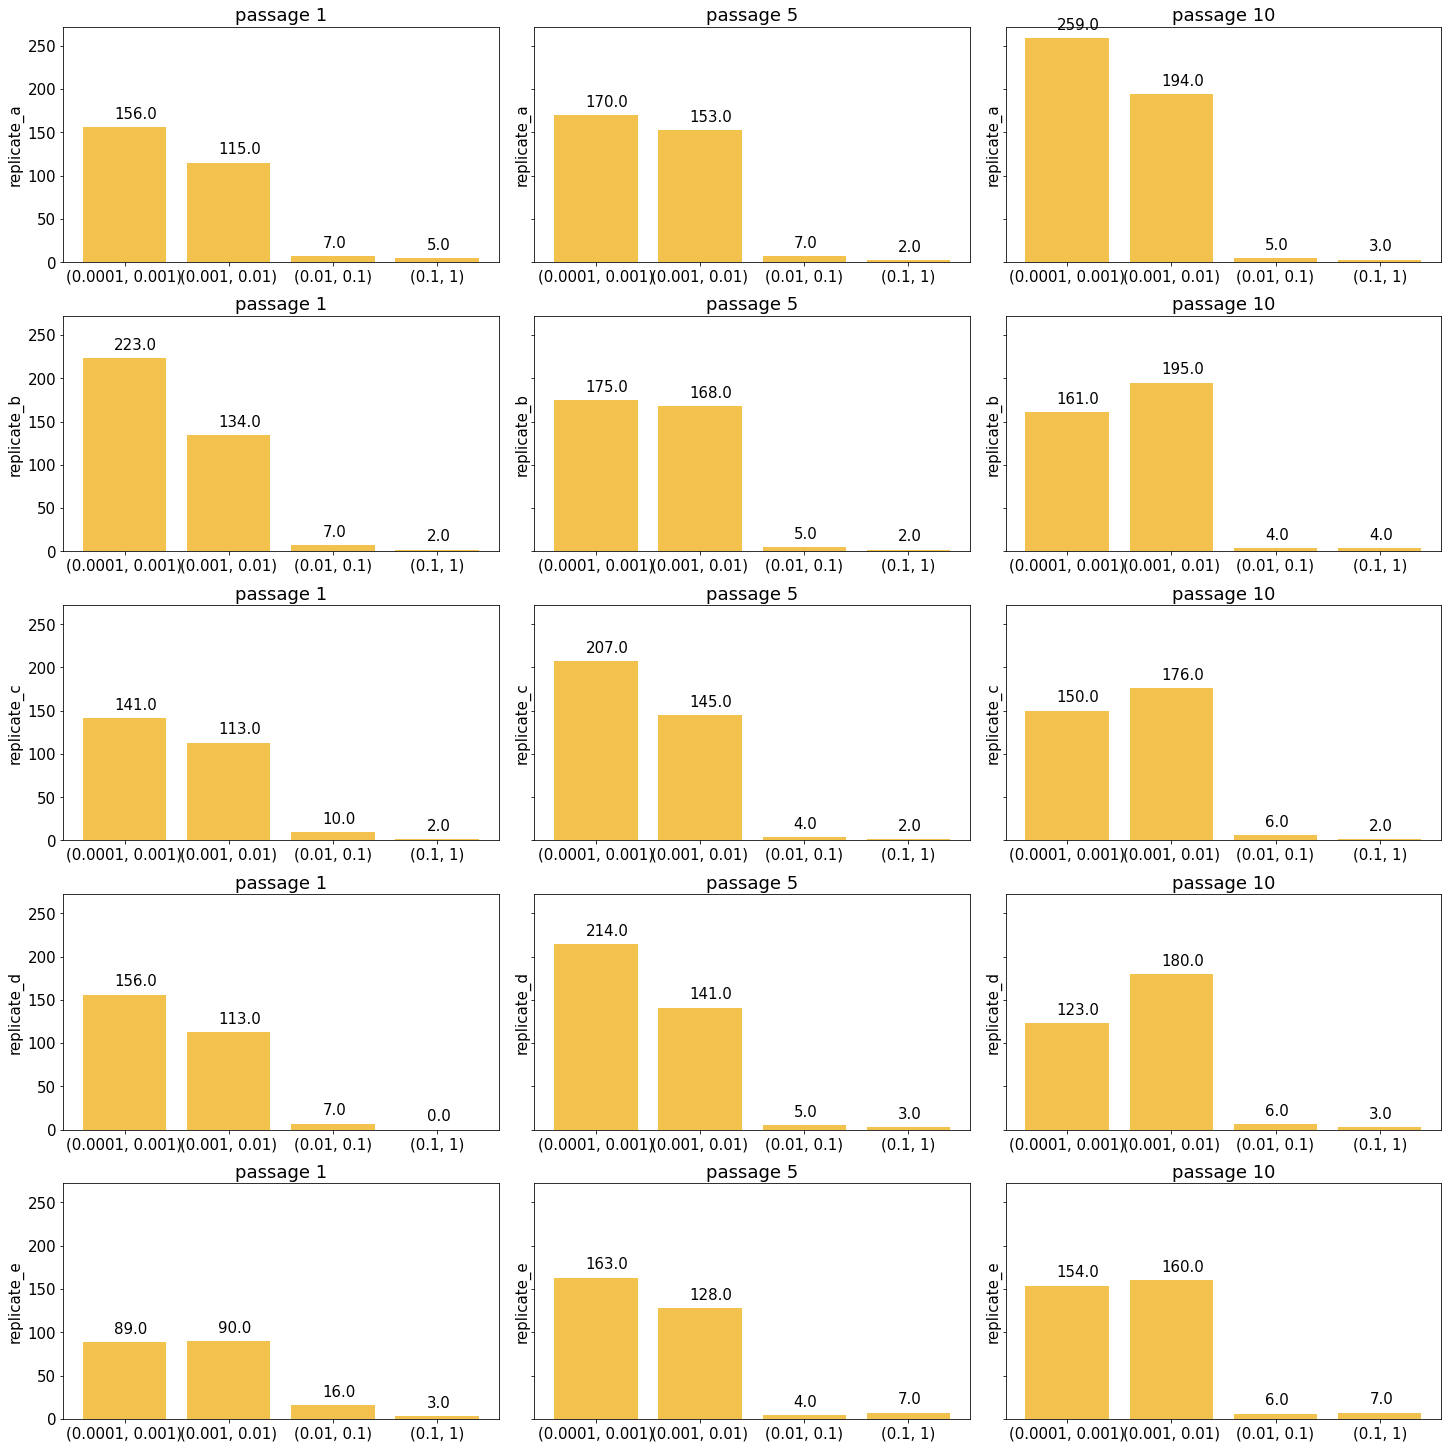

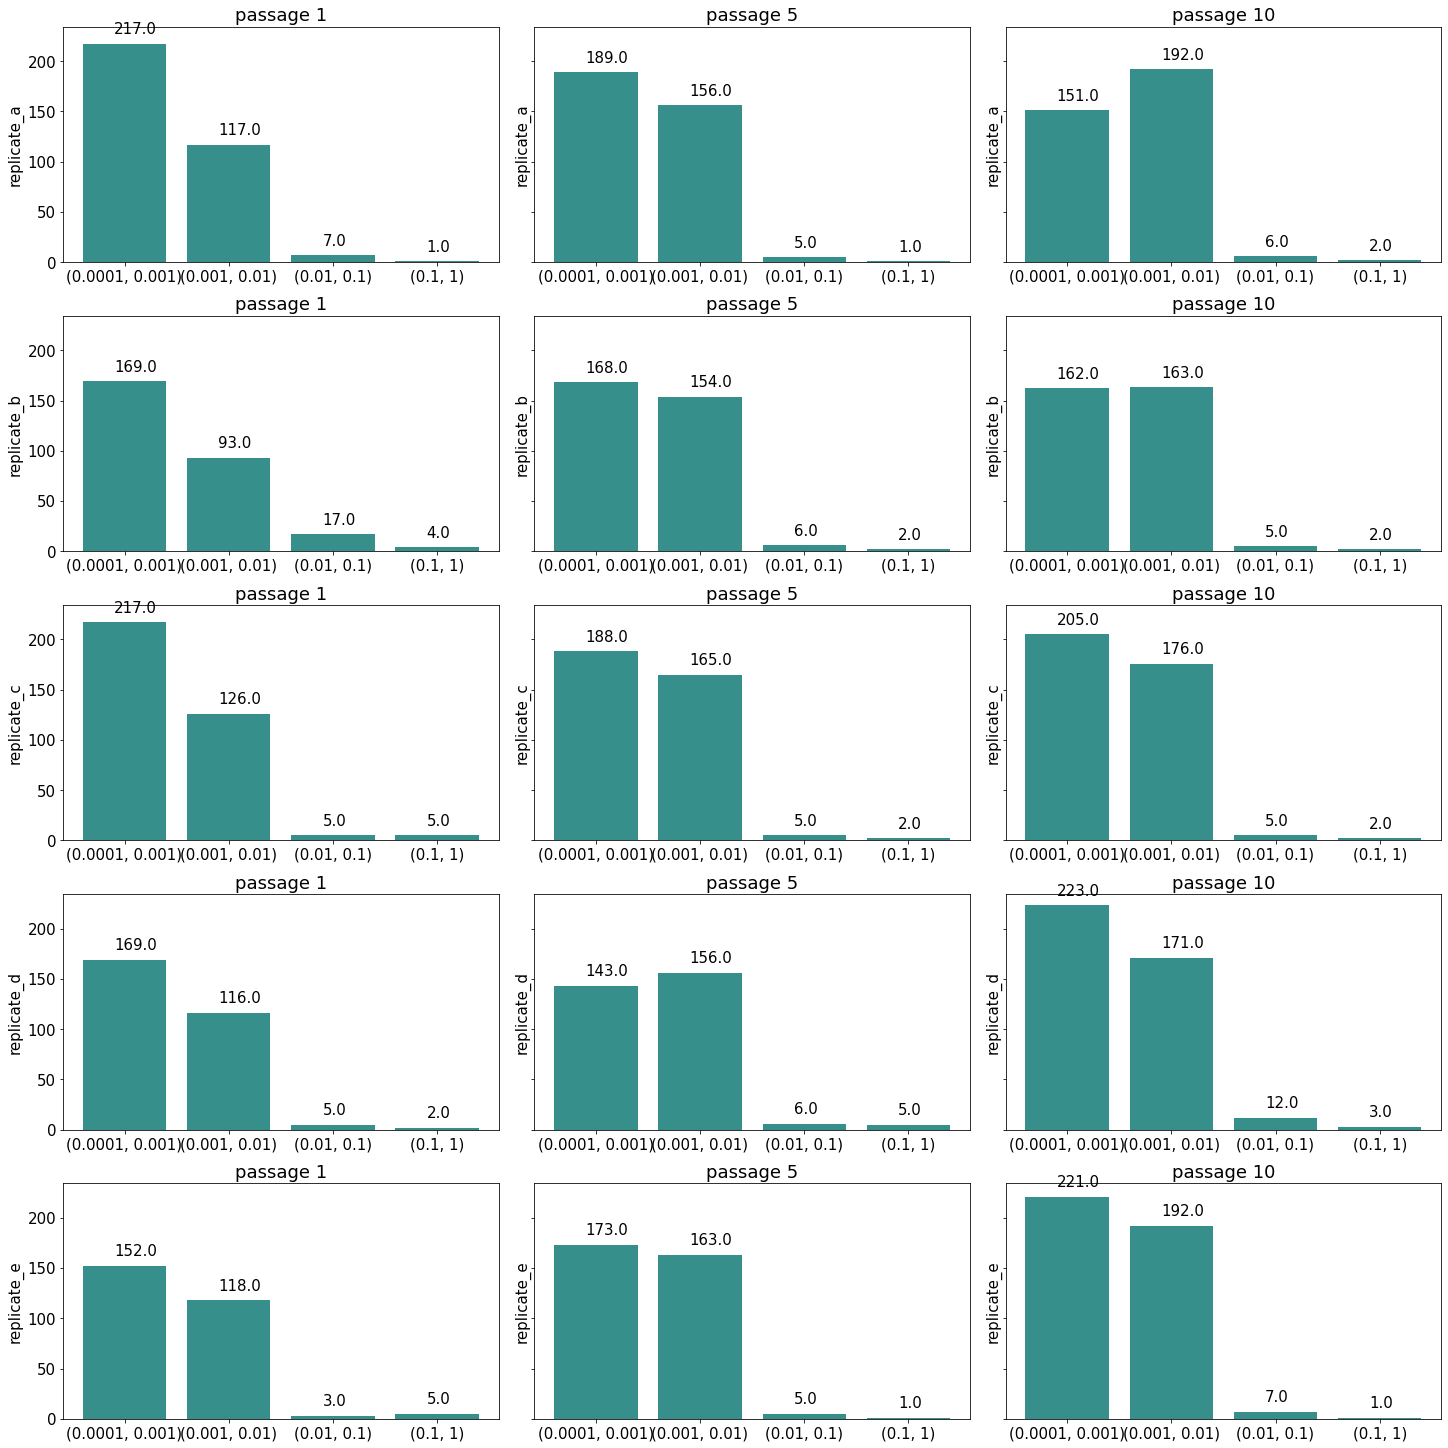

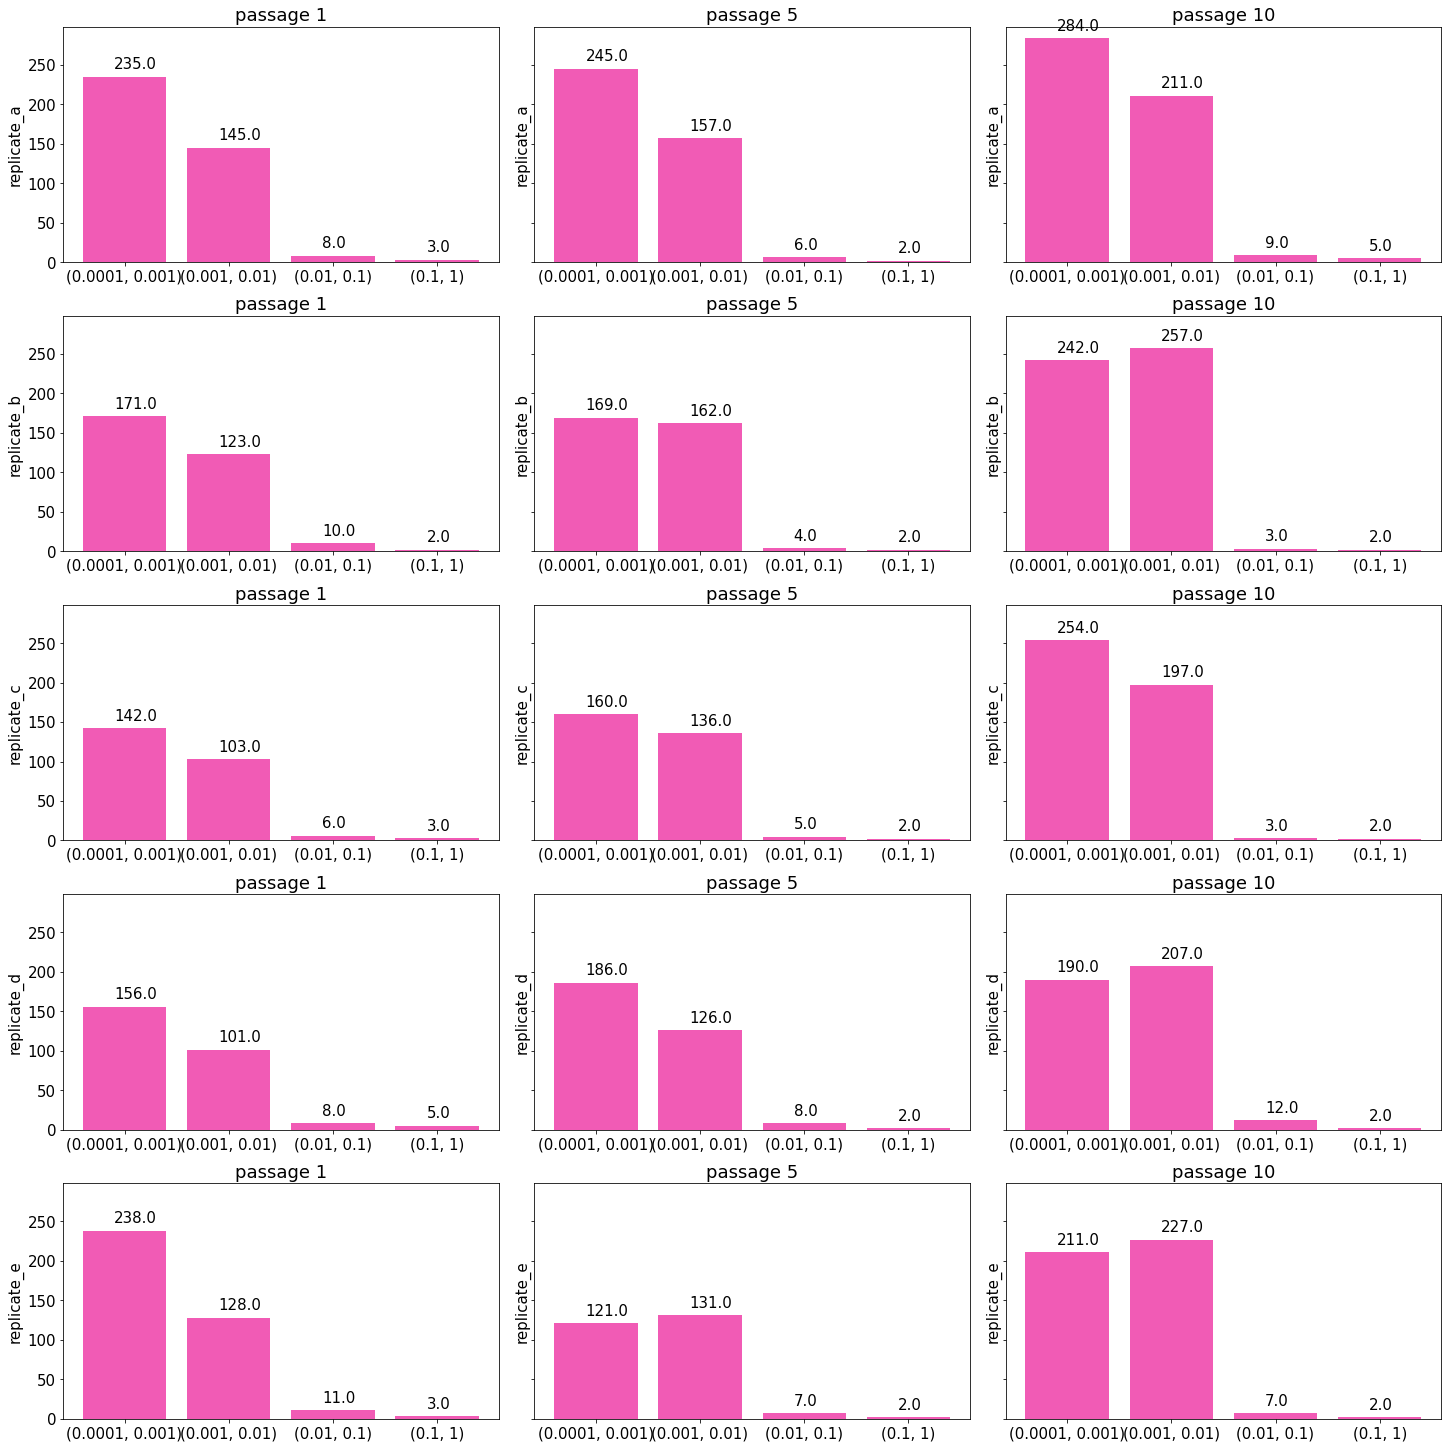

In [455]:
plot_mutation_spectrum(df_wildtype, "wild_type", output_dir, '#F2C14E')

plot_mutation_spectrum(df_overexpressed, "dicer_overexpressed", output_dir, '#368F8B')

plot_mutation_spectrum(df_ko, "dicer_knockout", output_dir, '#F15BB5')

In [470]:
def plot_average_and_per_replicate(df_diversity, col_name_diversity, output_dir): 
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    replicates = df_diversity['replicate'].unique()
    passages = df_diversity['passage'].unique()
    
    df_wildtype = df_diversity[df_diversity['sample']=='wild_type']
    df_ko = df_diversity[df_diversity['sample']=='dicer_ko']
    df_overexpressed = df_diversity[df_diversity['sample']=='dicer_overexpressed']


    for df,color,name in zip([df_wildtype, df_ko, df_overexpressed], 
                        ['#F2C14E', '#F15BB5', '#368F8B'], 
                        ['WT', 'KO', 'OE']):
        average_sum_mutation_frq = [np.mean(df[df['passage']== passage][col_name_diversity]) for passage in passages]
        ax1.plot(passages, average_sum_mutation_frq, c=color, marker='x', label=name)

    ax1.set_xticks([1,5,10])
    ax1.set_title('Average over replicates')
    ax1.set_ylabel(col_name_diversity)
    ax1.legend()

    for replicate in replicates:
        df_wildtype_rep = df_wildtype[df_wildtype['replicate']==replicate]
        ax2.plot(df_wildtype_rep['passage'], df_wildtype_rep[col_name_diversity] ,marker='x', c = '#F2C14E', label='wild type')

        df_ko_rep = df_ko[df_ko['replicate']==replicate]
        ax2.plot(df_ko_rep['passage'], df_ko_rep[col_name_diversity] ,marker='x', c = '#F15BB5', label='dicer knockout')

        df_overexpressed_rep = df_overexpressed[df_overexpressed['replicate']==replicate]
        ax2.plot(df_overexpressed_rep['passage'], df_overexpressed_rep[col_name_diversity] ,marker='x', c = '#368F8B' , label='dicer overexpressed')

    ax2.set_xticks([1,5,10])
    fig.tight_layout()
    #fig.savefig(output_dir+"Plot_"+col_name_diversity+".averaged.pdf") 


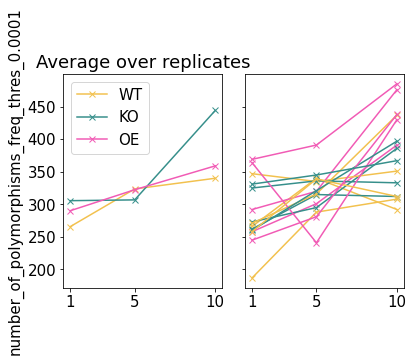

In [459]:
plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms_freq_thres_0.0001', output_dir)

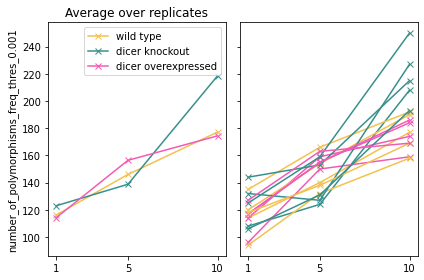

In [183]:
plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms_freq_thres_0.001', output_dir)

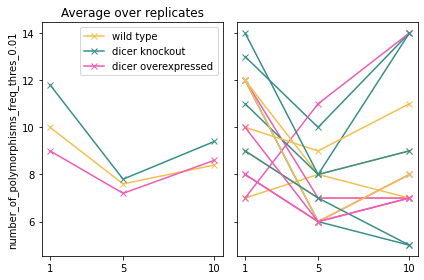

In [184]:
plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms_freq_thres_0.01', output_dir)

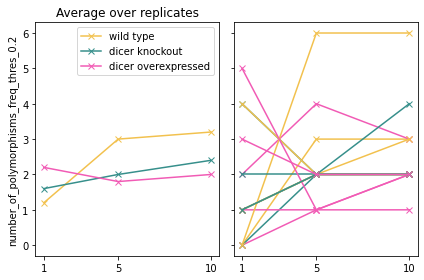

In [185]:
plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms_freq_thres_0.2', output_dir)

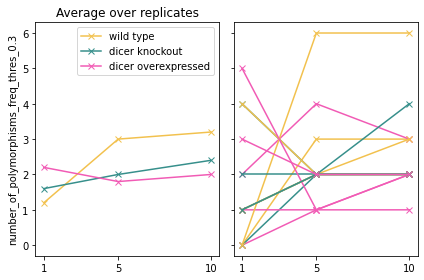

In [186]:
plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms_freq_thres_0.3', output_dir)

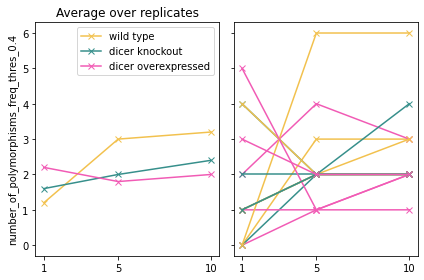

In [187]:
plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms_freq_thres_0.4', output_dir)

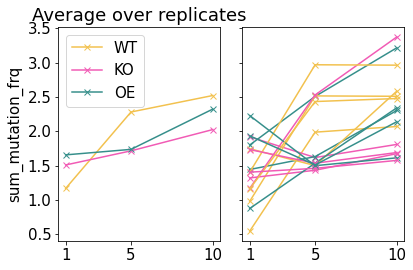

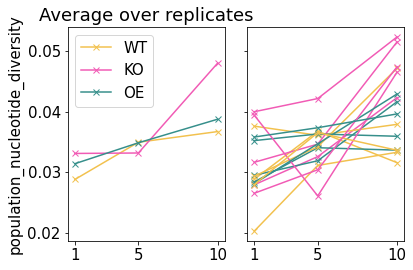

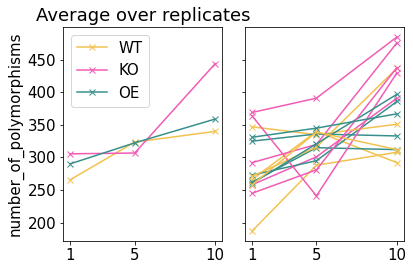

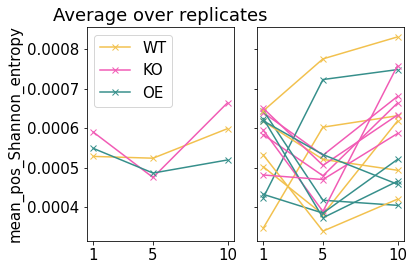

In [480]:
plot_average_and_per_replicate(df_diversity, 'sum_mutation_frq', output_dir)

plot_average_and_per_replicate(df_diversity, 'population_nucleotide_diversity', output_dir)

plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms', output_dir)

plot_average_and_per_replicate(df_diversity, 'mean_pos_Shannon_entropy', output_dir)

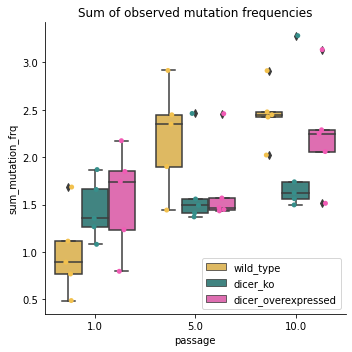

In [150]:
# sum_mutation_frq

g = sns.catplot(
        data=df_diversity,
        x="passage",
        y="sum_mutation_frq",
        hue="sample",
        #col="passage",
        #row='variable',
        kind="box",
        #row_order=['100', '1000', '10000'] , 
        hue_order=['wild_type', 'dicer_ko', 'dicer_overexpressed'] ,
        legend=False, 
        sharex=True,
        margin_titles=True,
        palette=sns.color_palette(['#F2C14E', '#368F8B', '#F15BB5']),
    )

g = sns.stripplot(
        data=df_diversity,
        x="passage",
        y="sum_mutation_frq",
        hue="sample",
        #col="passage",
        #row='variable',
        jitter=True,
        dodge=True, 
        #row_order=['100', '1000', '10000'] , 
        hue_order=['wild_type', 'dicer_ko', 'dicer_overexpressed'] ,
        #alpha=0.5,
        marker ='o',
        palette=sns.color_palette(['#F2C14E', '#368F8B', '#F15BB5']),
    )

handles, labels = g.get_legend_handles_labels()
# specify just one legend
l = g.legend(handles[0:3], labels[0:3])
g.set_title('Sum of observed mutation frequencies')

fig = g.figure
fig.tight_layout()
fig.savefig(output_dir+"Boxplot_sum_observed_mutation_frequencies.pdf") 